# Forecasting Monthly Armed Robberies in Boston

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import  datetime, timedelta
from statsmodels.tsa.stattools import  adfuller
from statsmodels.graphics.tsaplots import  plot_pacf, plot_acf
from statsmodels.graphics.tsaplots import  plot_acf
from statsmodels.graphics.gofplots import  qqplot
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.statespace.sarimax import  SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
from scipy.stats import boxcox
from statsmodels.tsa.api  import ExponentialSmoothing


from  pylab import rcParams
rcParams['figure.figsize'] = 25,8

import warnings
warnings.filterwarnings("ignore")

# Reading data 

## Splitting data onto dataset and validation

In [2]:
series = pd.read_csv('Robberies.csv')
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 106, Validation 12


In [3]:
dataset.head()

,Months,Robberies
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [4]:
validation.head()

,Months,Robberies
106,1974-11,452
107,1974-12,391
108,1975-01,500
109,1975-02,451
110,1975-03,375


# Preprocessing

In [5]:
dataset.tail()

,Months,Robberies
101,1974-06,287
102,1974-07,355
103,1974-08,460
104,1974-09,364
105,1974-10,487


## Transforming date column

In [6]:
# creating date range according to the data
# data has dates from 1966-01-31 to 1974-10-31 with monthly frequency
date = pd.date_range(start='1/1/1966', end='11/1/1974', freq='M')
date

DatetimeIndex(['1966-01-31', '1966-02-28', '1966-03-31', '1966-04-30',
               '1966-05-31', '1966-06-30', '1966-07-31', '1966-08-31',
               '1966-09-30', '1966-10-31',
               ...
               '1974-01-31', '1974-02-28', '1974-03-31', '1974-04-30',
               '1974-05-31', '1974-06-30', '1974-07-31', '1974-08-31',
               '1974-09-30', '1974-10-31'],
              dtype='datetime64[ns]', length=106, freq='M')

In [7]:
# replacing original date column with newly created
dataset['Months'] = date

# setting date column as index of the dataframe
dataset.set_index('Months', inplace=True)
dataset.head()

,Robberies
Months,
1966-01-31,41
1966-02-28,39
1966-03-31,50
1966-04-30,40
1966-05-31,43


# Data analysis

In [8]:
# stats
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Robberies,106.0,173.103774,112.231133,29.0,74.75,144.5,271.75,487.0


**Inference**
1. Total of 106 records
2. Mean robberies as 173.10
3. Standard deviation is larger than mean: robberies are increasing yearly

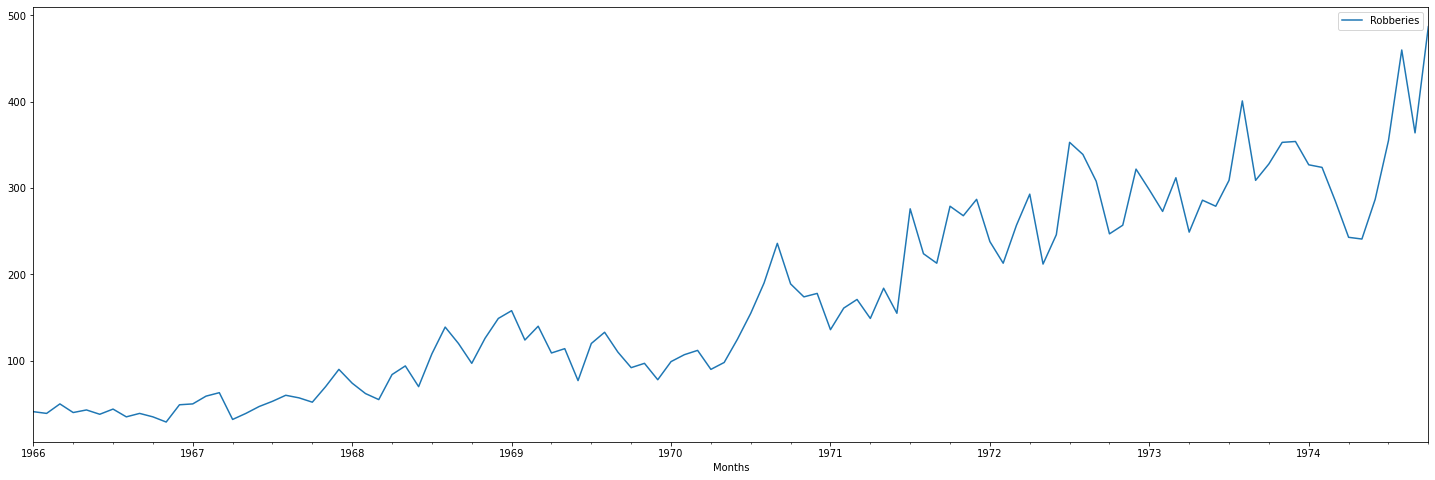

In [9]:
dataset.plot()
plt.show()

**Inference:** Linear up-trend but no seasionality

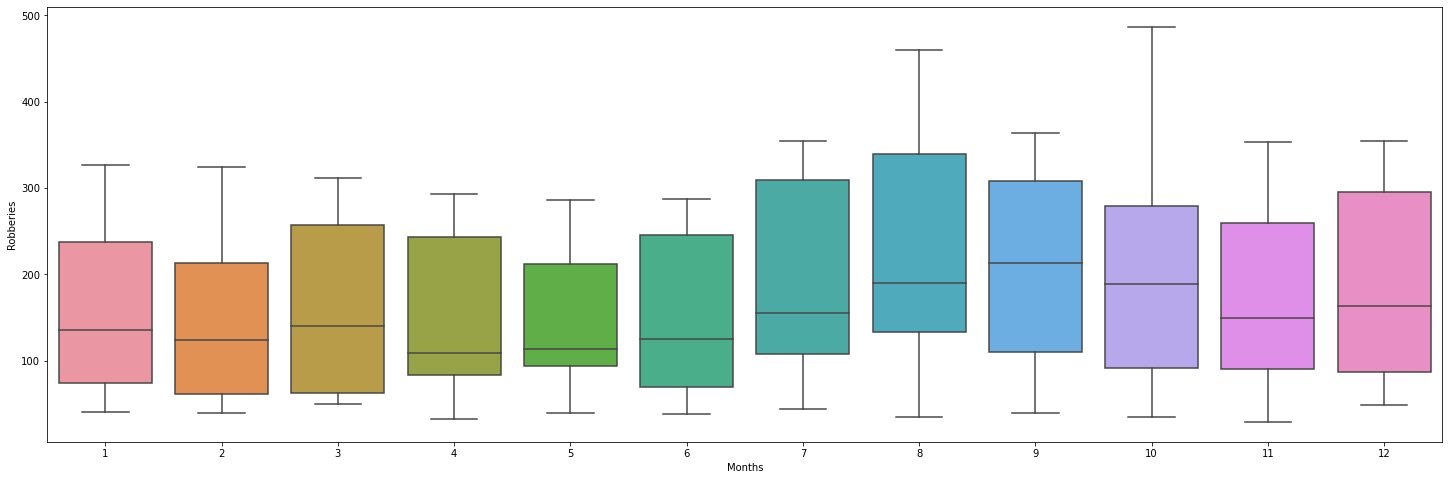

In [10]:
sns.boxplot(x = dataset.index.month, y = dataset['Robberies'])
plt.show()

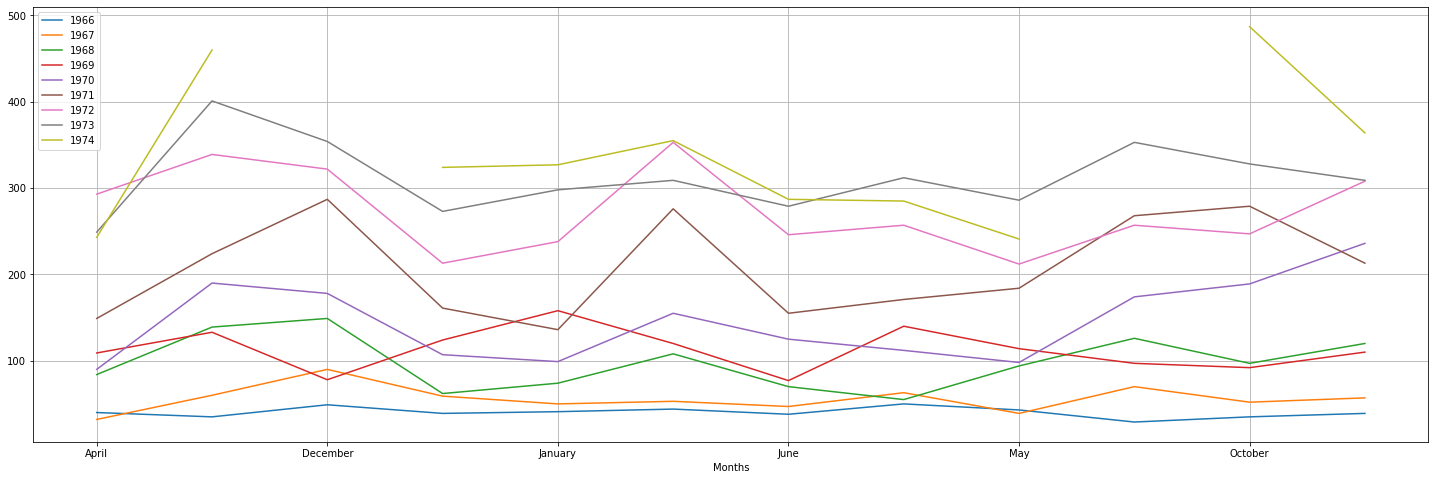

In [11]:
monthly_rabberies_across_years = pd.pivot_table(dataset,
                                                values = 'Robberies',
                                                columns = dataset.index.year,
                                                index = dataset.index.month_name())
monthly_rabberies_across_years.plot()
plt.grid()
plt.legend(loc='best');

**Inference:** Both graph shows no strong seasonality

# Stationary test
**Stationary test means all the data are around mean and varience of the entire data. To forecast any time series, stationary data is required. In case, data is not stationary we use differencing technique to transform non-stationary series into stationary series** 

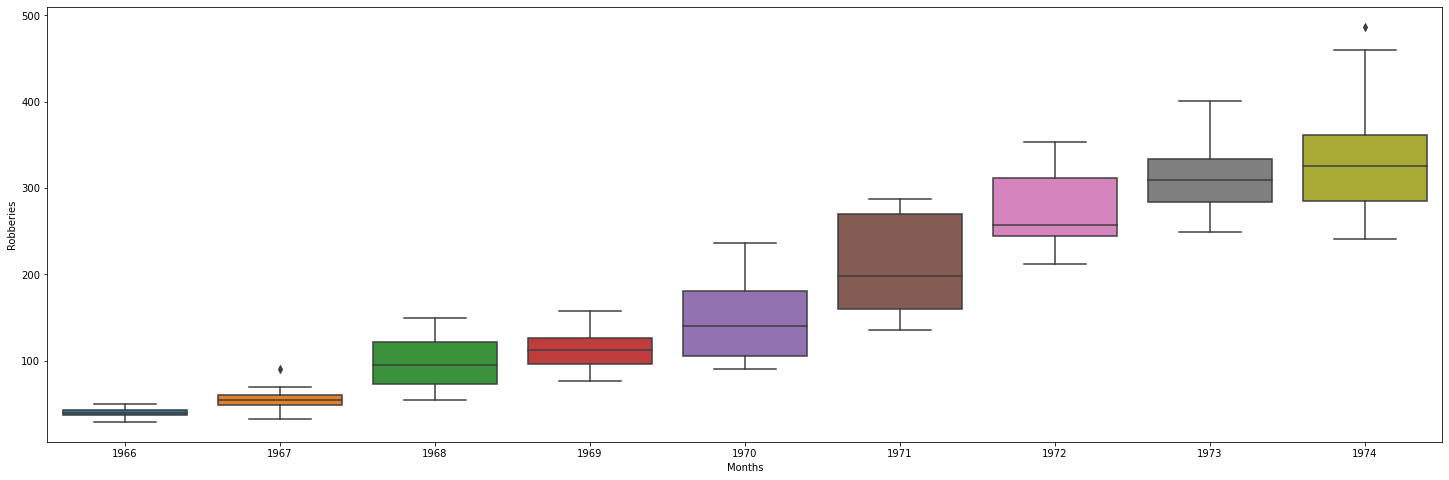

In [12]:
# year wise box plot
sns.boxplot(x = dataset.index.year, y = dataset['Robberies'])
plt.show()

**Inference:** Graph shows strong up-trend, which means presence of non-stationary data. Let's check bt **A**uto**c**orrelation **F**unction plot and **P**artial **A**utocorrelation **F**unction plot.

## ACF and PCAF plots

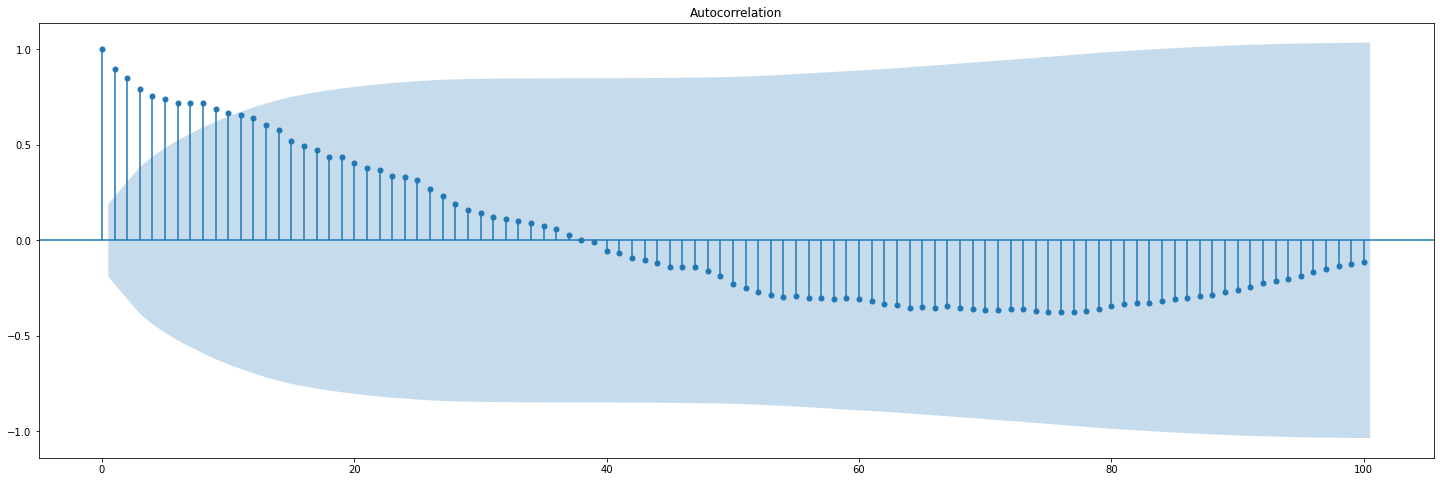

In [13]:
# ACF plot
plot_acf(dataset, lags=100);

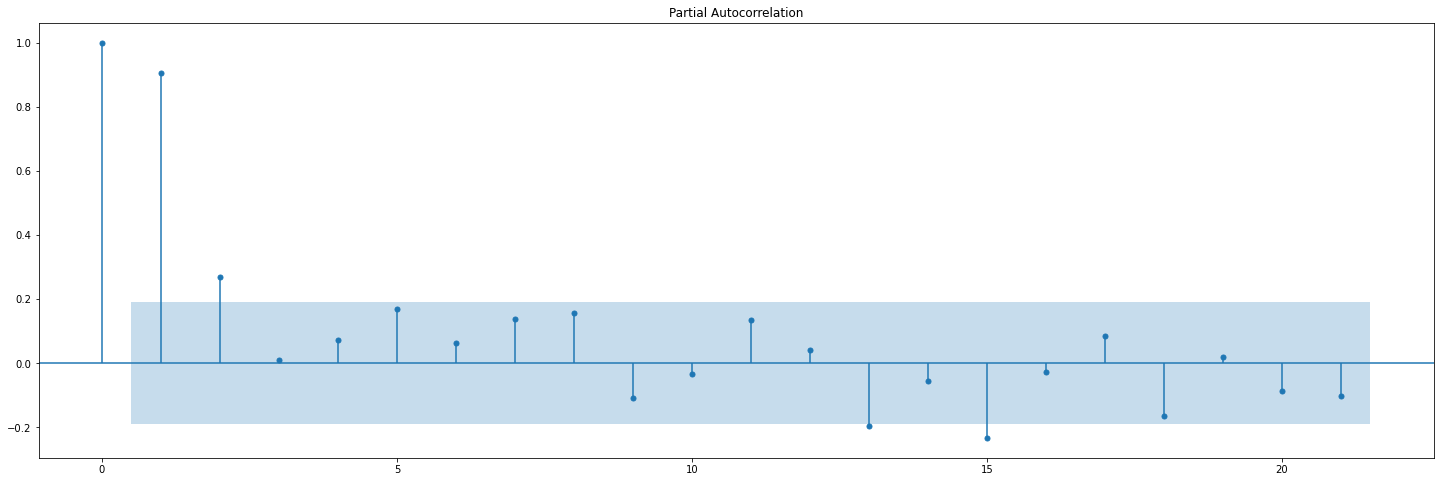

In [14]:
# PACF plot
plot_pacf(dataset);

**Inference:** Slow decay in in ACF and random trend in PACF shows trend in data. Let's conform by statistical test.

## Dickey-Fuller test

In [15]:
'''
Null hypothesis:Series is not stationary
Alternate hypothesis: Series is stationary
'''

test_result = adfuller(dataset.values)
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
    print('\t%s: %.5f' % (key, value))

ADF Statistic: 0.797485
p-value: 0.991595
Critical Values:
	1%: -3.50270
	5%: -2.89316
	10%: -2.58364


**Inference:** p-value is greater than threshold 0.05(commenly taken threshold in statistics). Hence, we fail to reject hull hypothesis.So the series is  non-stationary.<br>
**Differencing is required**

# Differencing by 1 lab value
(`y` at time `t`) - (`y` at time `t-1`)

In [16]:
df_diff1 = dataset.diff(periods=1).dropna()

test_result = adfuller(df_diff1.values)
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
    print('\t%s: %.5f' % (key, value))

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.50270
	5%: -2.89316
	10%: -2.58364


**Inference:** p-value is less than threshold 0.05(commenly taken threshold in statistics). Hence, we  reject hull hypothesis.So the series is stationary at t-1 differencing.<br>

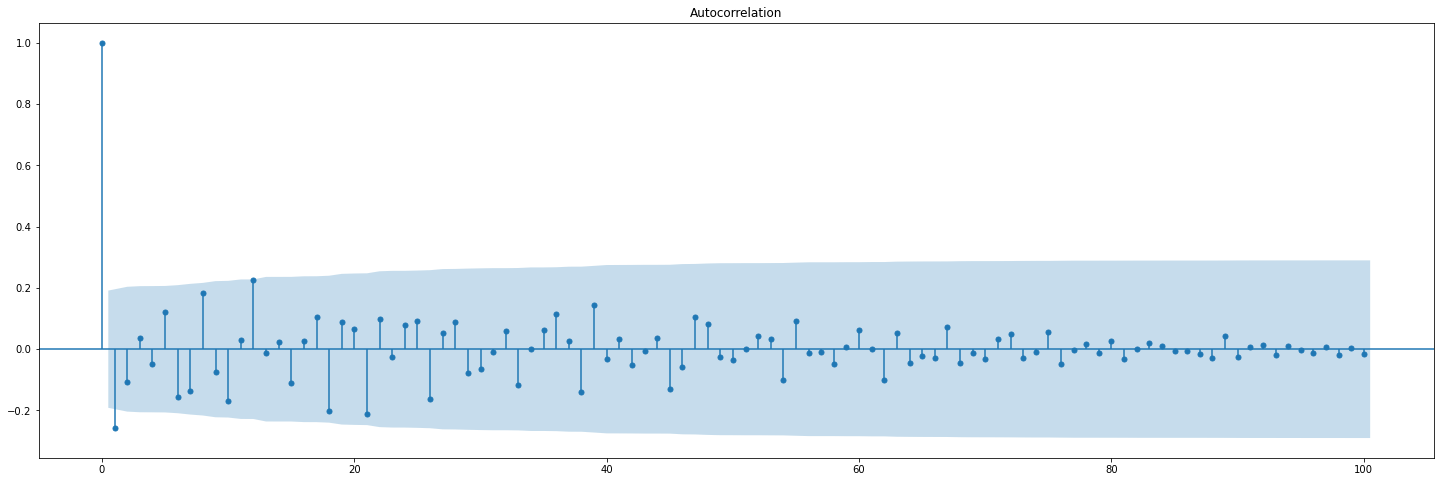

In [17]:
plot_acf(df_diff1, lags=100);

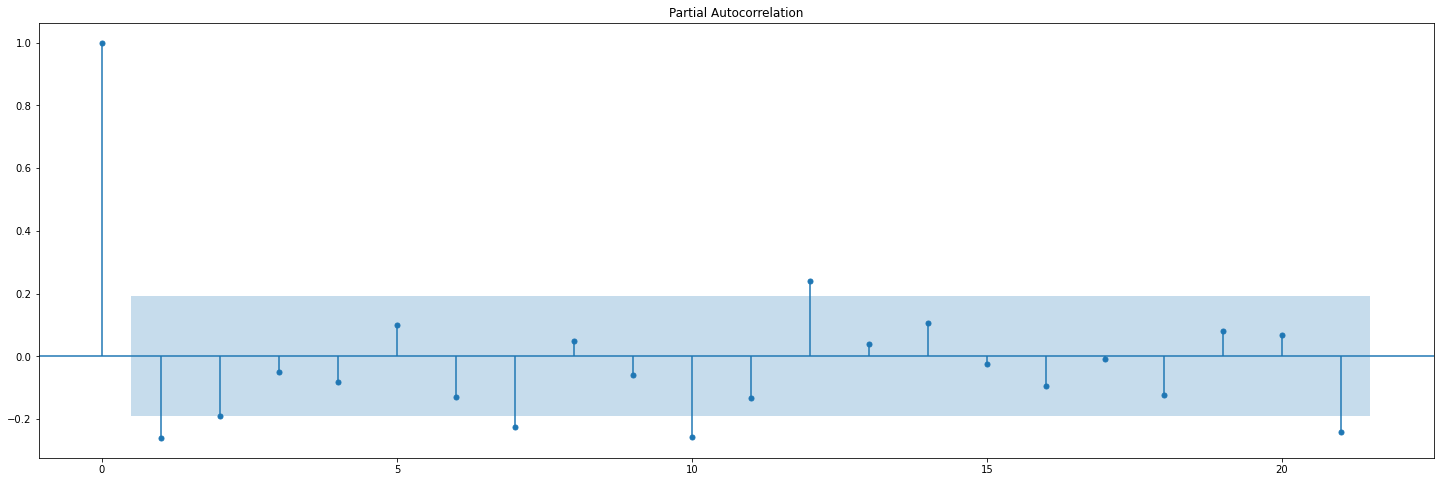

In [18]:
plot_pacf(df_diff1);

# Train-test split

In [19]:
dataset.index

DatetimeIndex(['1966-01-31', '1966-02-28', '1966-03-31', '1966-04-30',
               '1966-05-31', '1966-06-30', '1966-07-31', '1966-08-31',
               '1966-09-30', '1966-10-31',
               ...
               '1974-01-31', '1974-02-28', '1974-03-31', '1974-04-30',
               '1974-05-31', '1974-06-30', '1974-07-31', '1974-08-31',
               '1974-09-30', '1974-10-31'],
              dtype='datetime64[ns]', name='Months', length=106, freq=None)

In [20]:
# split data such that last two years are taken into test data remainig for train data
train_end = datetime(1972, 12, 31)
test_end = datetime(1974, 10, 31)

train = dataset[ : train_end]
test = dataset[train_end+timedelta(days=1) : test_end]

In [21]:
train.shape

(84, 1)

In [22]:
test.shape

(22, 1)

# ARIMA model
**Since, we have trend to capture ARIMA model is best suited**

## Building the model

In [23]:
# order = (1, 1, 1): ACF value 1, Differencing by 1, PACF value 1
arima_model = ARIMA(train, order = (1, 1, 1))
model_fit = arima_model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Robberies   No. Observations:                   83
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -398.109
Method:                       css-mle   S.D. of innovations             29.196
Date:                Wed, 12 May 2021   AIC                            804.219
Time:                        20:08:18   BIC                            813.894
Sample:                    02-28-1966   HQIC                           808.106
                         - 12-31-1972                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.2580      0.887      3.671      0.000       1.519       4.997
ar.L1.D.Robberies     0.4363      0.151      2.894      0.004       0.141       0.732
ma.L1.D.Robberies    -0.

## Forecasting

In [24]:
arima_forecast = model_fit.forecast(steps = len(test))

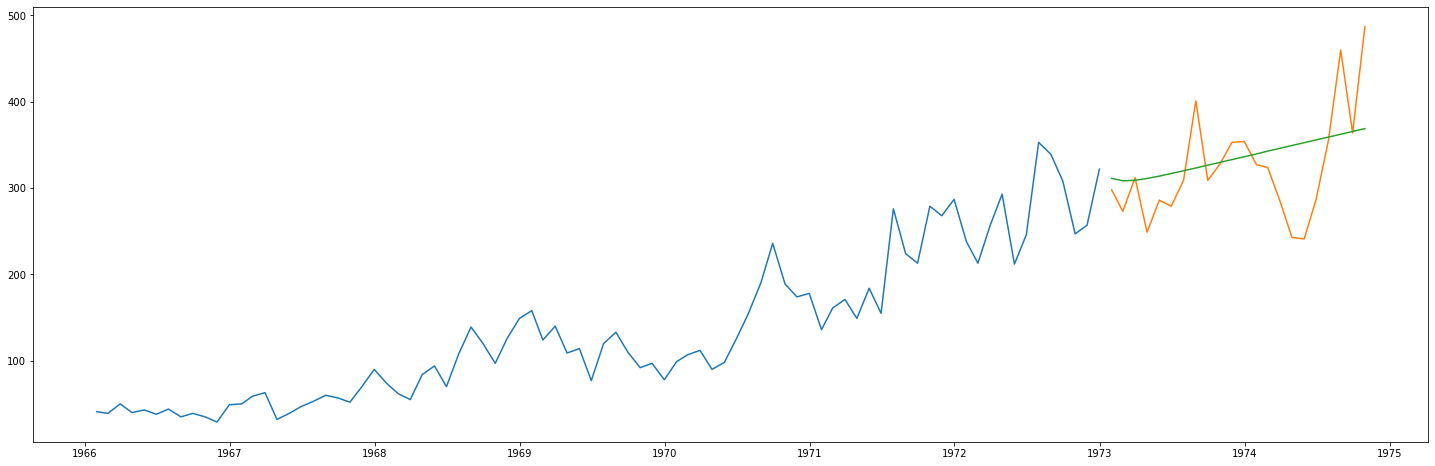

In [25]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, arima_forecast[0], label='Forecast')

In [26]:
rmse = np.sqrt(mean_squared_error(test.Robberies, arima_forecast[0]))
print(rmse)

56.78931138698121


## Mean Absolute Percentage Error

In [27]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

mape = MAPE(test['Robberies'].values, arima_forecast[0])
mape

13.580517302092906

**Incerence:** There is almost 14% of error

In [28]:
results_df = pd.DataFrame({'Test RMSE': rmse,'Test MAPE':mape}
                           ,index=['ARIMA(1,1,1)'])

results_df

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",56.789311,13.580517


## Hyperparameter tuning
**We will look for paramerers with least AIC value**

In [29]:
# parameters for grid search
p = q = range(0, 4)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('parameter combinations for the Model')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

parameter combinations for the Model
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [30]:
# Grid search technique
arima_df = pd.DataFrame(columns=['param', 'AIC'])

for param in pdq:
    try:
        model = ARIMA(train, order = param)
        model_fit = model.fit()
        print('ARIMA_params',param, '- AIC{}', model_fit.aic)
        arima_df = arima_df.append({'param': param, 'AIC': model_fit.aic}, ignore_index = True)
    except:
        continue

print('==============================================')
arima_df = arima_df.sort_values('AIC')
print('Best params for ARIMA')
print(arima_df.head(1))

ARIMA_params (0, 1, 0) - AIC{} 815.9422373489978
ARIMA_params (0, 1, 1) - AIC{} 808.6725704875938
ARIMA_params (0, 1, 2) - AIC{} 802.3291631583744
ARIMA_params (0, 1, 3) - AIC{} 804.3145074913936
ARIMA_params (1, 1, 0) - AIC{} 814.8292011147407
ARIMA_params (1, 1, 1) - AIC{} 804.2187211450786
ARIMA_params (1, 1, 2) - AIC{} 804.308379183173
ARIMA_params (1, 1, 3) - AIC{} 805.5728238177652
ARIMA_params (2, 1, 0) - AIC{} 807.3987489833627
ARIMA_params (2, 1, 1) - AIC{} 804.8351894545615
ARIMA_params (2, 1, 2) - AIC{} 806.0674915630154
ARIMA_params (3, 1, 0) - AIC{} 806.7087714564911
ARIMA_params (3, 1, 1) - AIC{} 806.2707243568356
ARIMA_params (3, 1, 2) - AIC{} 808.0606665293542
ARIMA_params (3, 1, 3) - AIC{} 809.3205316104335
Best params for ARIMA
       param         AIC
2  (0, 1, 2)  802.329163


In [31]:
arima_model = ARIMA(train, order = (0, 1, 2))
model_fit = arima_model.fit()

arima_forecast = model_fit.forecast(steps = len(test))

In [32]:
rmse = np.sqrt(mean_squared_error(test.Robberies, arima_forecast[0]))
print(rmse)

57.15782810614509


In [33]:
mape = MAPE(test['Robberies'].values, arima_forecast[0])
print(mape)

13.941902255343008


In [34]:
results_df_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['Tuned ARIMA(0, 1, 2)'])

results_df = pd.concat([results_df, results_df_temp])
results_df

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",56.789311,13.580517
"Tuned ARIMA(0, 1, 2)",57.157828,13.941902


**Inference:** No much improvement in the model accuracy

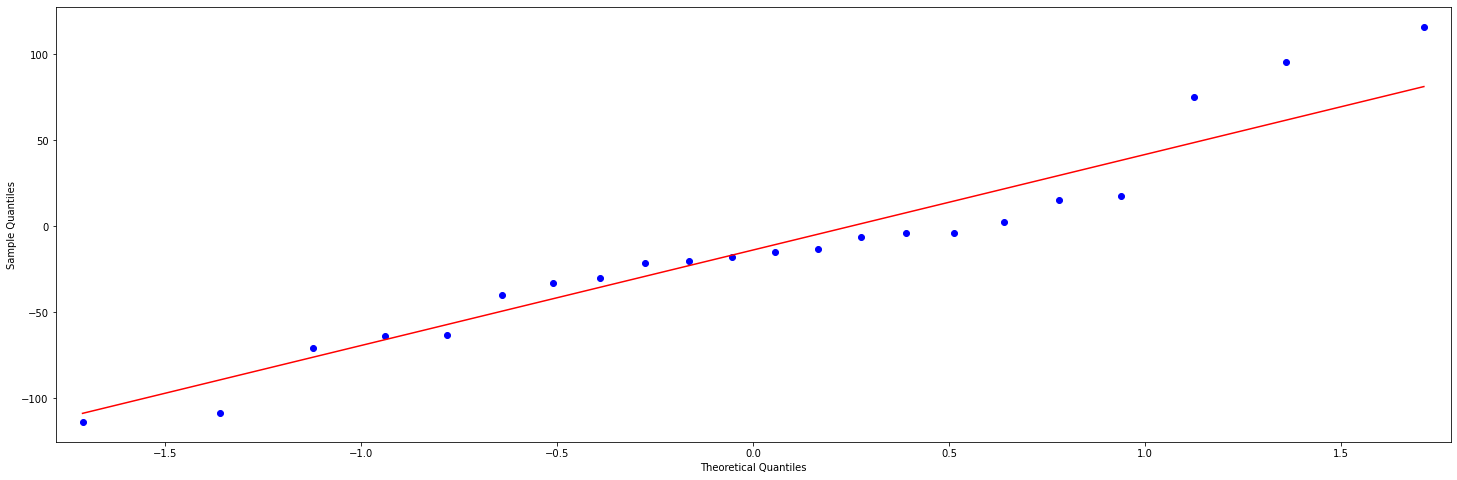

In [35]:
residuals = test['Robberies'] - arima_forecast[0]
qqplot(residuals,line="s");

# Transformation
**Let's check if transforming the data with Box-Cox method will improve our model** 

In [36]:
data = [x[0] for x in train.values]
transformed, lam = boxcox(data)

# the forecast will be Box-Cox transformed values.
# Hence, we need to invest the values back to original scale.
def boxcox_inverse(value, lam):
    if lam == 0:
        return np.exp(value)
    return np.exp(np.log(lam * value + 1) / lam)

In [37]:
# Fit the model with transformed data
arima_model = ARIMA(transformed, order=(0, 1, 2))
model_fit = arima_model.fit()

# Forecast for test
arima_forecast = model_fit.forecast(steps = len(test))

# Invert the transformation
arima_forecast = boxcox_inverse(arima_forecast[0], lam)

# Check RMSE
rmse = np.sqrt(mean_squared_error(test.Robberies, arima_forecast))

# Check error
mape = MAPE(test['Robberies'].values, arima_forecast[0])

results_df_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['Transformed ARIMA(0, 1, 2)'])

results_df = pd.concat([results_df, results_df_temp])
results_df

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",56.789311,13.580517
"Tuned ARIMA(0, 1, 2)",57.157828,13.941902
"Transformed ARIMA(0, 1, 2)",98.392693,14.327814


**Inference:** Error increased, transformation is a bad idea

**Concluion:** We will stick to paramerets which we got from hyper parameter tuning. That is, ACF=0, Differencing=1 and PACF=2 (0, 1, 2) withoud transformation

## Rolling forecasting to capture random variation

In [38]:
predictions = []
data = [x[0] for x in train.values]


for i in range(0, len(test)):
        
    # predict
    model = ARIMA(data, order=(0, 1, 2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    # observation
    obs = test.iloc[i].values[0]
    data.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=316.063, Expected=298.000
>Predicted=294.466, Expected=273.000
>Predicted=289.635, Expected=312.000
>Predicted=314.759, Expected=249.000
>Predicted=268.675, Expected=286.000
>Predicted=303.095, Expected=279.000
>Predicted=286.441, Expected=309.000
>Predicted=309.455, Expected=401.000
>Predicted=363.141, Expected=309.000
>Predicted=304.979, Expected=328.000
>Predicted=336.240, Expected=353.000
>Predicted=342.814, Expected=354.000
>Predicted=347.675, Expected=327.000
>Predicted=335.842, Expected=324.000
>Predicted=338.449, Expected=285.000
>Predicted=314.714, Expected=243.000
>Predicted=290.336, Expected=241.000
>Predicted=280.614, Expected=287.000
>Predicted=302.079, Expected=355.000
>Predicted=340.210, Expected=460.000
>Predicted=405.172, Expected=364.000
>Predicted=333.755, Expected=487.000


In [39]:
rmse = np.sqrt(mean_squared_error(test.Robberies, predictions))
rmse

57.45378971393004

In [40]:
mape = MAPE(test['Robberies'].values, predictions)
mape

15.944191770817762

In [41]:
results_df_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['Rolling ARIMA(0, 1, 2)'])

results_df = pd.concat([results_df, results_df_temp])
results_df

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",56.789311,13.580517
"Tuned ARIMA(0, 1, 2)",57.157828,13.941902
"Transformed ARIMA(0, 1, 2)",98.392693,14.327814
"Rolling ARIMA(0, 1, 2)",57.453790,15.944192


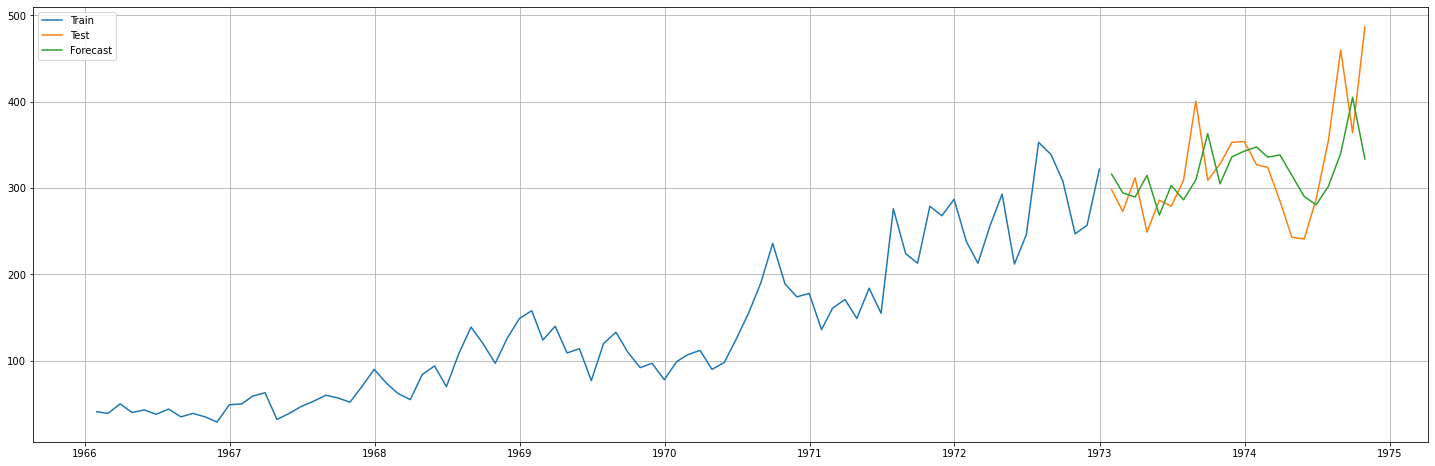

In [42]:
plt.plot(train, label='Train')
plt.plot(test.index,test, label='Test')
plt.plot(test.index, predictions, label='Forecast')
plt.legend(loc='best')
plt.grid()

**Inference:** Our goal is to reduce MAPE. Let's see if Exponential Smoothing will do a better job.

# Exponential Smoothing model

In [43]:
model_TES_add = ExponentialSmoothing(train, trend='additive', seasonal='additive', initialization_method='estimated')
model_TES_add = model_TES_add.fit(optimized=True)
model_TES_add.summary()

Dep. Variable:,Robberies,No. Observations:,84
Model:,ExponentialSmoothing,SSE,54847.730
Optimized:,True,AIC,576.446
Trend:,Additive,BIC,615.339
Seasonal:,Additive,AICC,586.969
Seasonal Periods:,12,Date:,"Wed, 12 May 2021"
Box-Cox:,False,Time:,20:08:22
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4907095,alpha,True
smoothing_trend,2.4545e-05,beta,True


In [44]:
TES_add_predict =  model_TES_add.forecast(len(test))

rmse = np.sqrt(mean_squared_error(test.Robberies, TES_add_predict))
mape = MAPE(test['Robberies'], TES_add_predict)

In [45]:
results_df_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['Exponential Smoothing'])

results_df = pd.concat([results_df, results_df_temp])
results_df

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",56.789311,13.580517
"Tuned ARIMA(0, 1, 2)",57.157828,13.941902
"Transformed ARIMA(0, 1, 2)",98.392693,14.327814
"Rolling ARIMA(0, 1, 2)",57.453790,15.944192
Exponential Smoothing,48.481606,10.290975


**Inference:** Final model is Exponential Smoothing

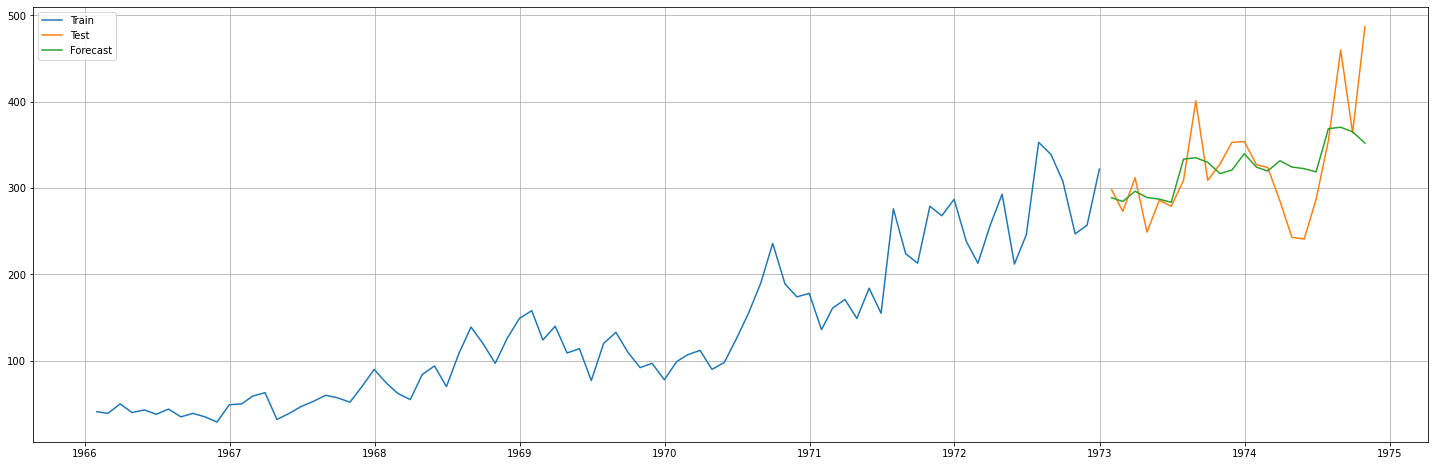

In [46]:
plt.plot(train, label='Train')
plt.plot(test.index,test, label='Test')
plt.plot(test.index, TES_add_predict, label='Forecast')
plt.legend(loc='best')
plt.grid()

# Validation

In [47]:
validation.shape

(12, 2)

In [48]:
validation.head()

,Months,Robberies
106,1974-11,452
107,1974-12,391
108,1975-01,500
109,1975-02,451
110,1975-03,375


In [49]:
validation.tail()

,Months,Robberies
113,1975-06,316
114,1975-07,398
115,1975-08,394
116,1975-09,431
117,1975-10,431


## Preprocessing validation data

In [50]:
date = pd.date_range('11/1/1974', '11/1/1975', freq='M')
date

DatetimeIndex(['1974-11-30', '1974-12-31', '1975-01-31', '1975-02-28',
               '1975-03-31', '1975-04-30', '1975-05-31', '1975-06-30',
               '1975-07-31', '1975-08-31', '1975-09-30', '1975-10-31'],
              dtype='datetime64[ns]', freq='M')

In [51]:
validation['Months'] = date
validation.set_index('Months', inplace=True)
validation.head()

,Robberies
Months,
1974-11-30,452
1974-12-31,391
1975-01-31,500
1975-02-28,451
1975-03-31,375


## Model fitting and forecasting

In [52]:
model_TES_add = ExponentialSmoothing(dataset, trend='additive', seasonal='additive', initialization_method='estimated')
model_TES_add = model_TES_add.fit(optimized=True)
model_TES_add.summary()

Dep. Variable:,Robberies,No. Observations:,106
Model:,ExponentialSmoothing,SSE,99416.284
Optimized:,True,AIC,757.425
Trend:,Additive,BIC,800.040
Seasonal:,Additive,AICC,765.287
Seasonal Periods:,12,Date:,"Wed, 12 May 2021"
Box-Cox:,False,Time:,20:08:22
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5197626,alpha,True
smoothing_trend,0.0005491,beta,True


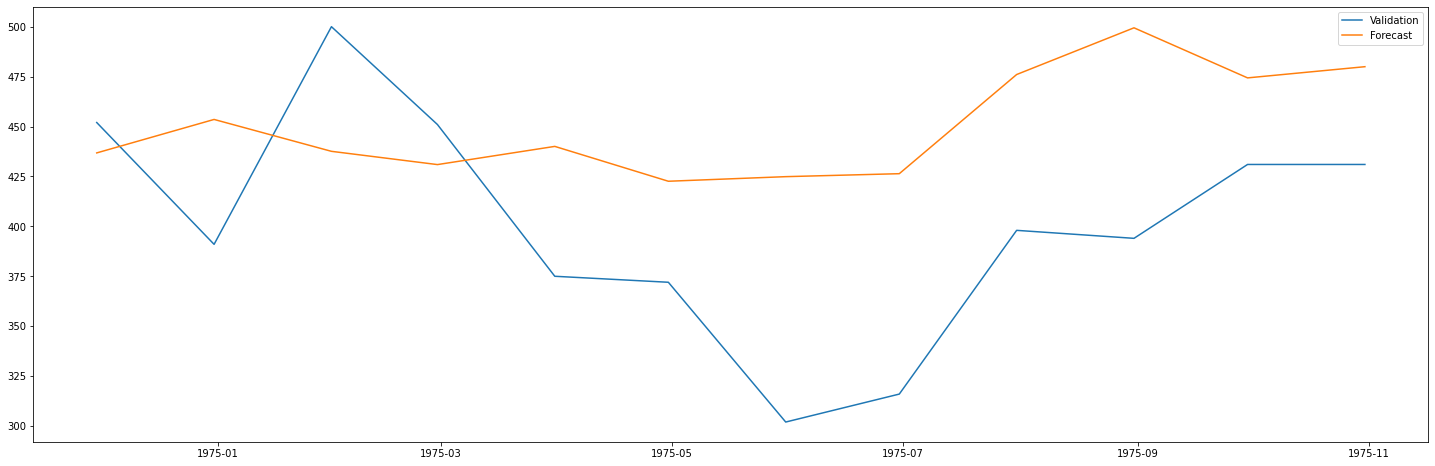

In [53]:
TES_add_predict =  model_TES_add.forecast(len(validation))
plt.plot(validation, label='Validation')
plt.plot(validation.index, TES_add_predict, label='Forecast')
plt.legend()
plt.show()

# Forecasting for next 1 year

In [54]:
series.head()

,Months,Robberies
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [55]:
series.tail()

,Months,Robberies
113,1975-06,316
114,1975-07,398
115,1975-08,394
116,1975-09,431
117,1975-10,431


## Preprocessing original dada

In [56]:
date = pd.date_range('1/1/1966', '11/1/1975', freq='M')
date

DatetimeIndex(['1966-01-31', '1966-02-28', '1966-03-31', '1966-04-30',
               '1966-05-31', '1966-06-30', '1966-07-31', '1966-08-31',
               '1966-09-30', '1966-10-31',
               ...
               '1975-01-31', '1975-02-28', '1975-03-31', '1975-04-30',
               '1975-05-31', '1975-06-30', '1975-07-31', '1975-08-31',
               '1975-09-30', '1975-10-31'],
              dtype='datetime64[ns]', length=118, freq='M')

In [57]:
series['Months'] = date
series.set_index('Months', inplace=True)
series.head()

,Robberies
Months,
1966-01-31,41
1966-02-28,39
1966-03-31,50
1966-04-30,40
1966-05-31,43


## Manually creating next 1 year date fields

In [58]:
forecast_date = pd.date_range('11/1/1975', '11/1/1976', freq='M')
forecast_date

DatetimeIndex(['1975-11-30', '1975-12-31', '1976-01-31', '1976-02-29',
               '1976-03-31', '1976-04-30', '1976-05-31', '1976-06-30',
               '1976-07-31', '1976-08-31', '1976-09-30', '1976-10-31'],
              dtype='datetime64[ns]', freq='M')

## Model builting and forecasting the trend

In [59]:
model_TES_add = ExponentialSmoothing(series, trend='additive', seasonal='additive', initialization_method='estimated')
model_TES_add = model_TES_add.fit(optimized=True)
TES_add_predict =  model_TES_add.forecast(12)

In [60]:
yhat

array([333.75513118])

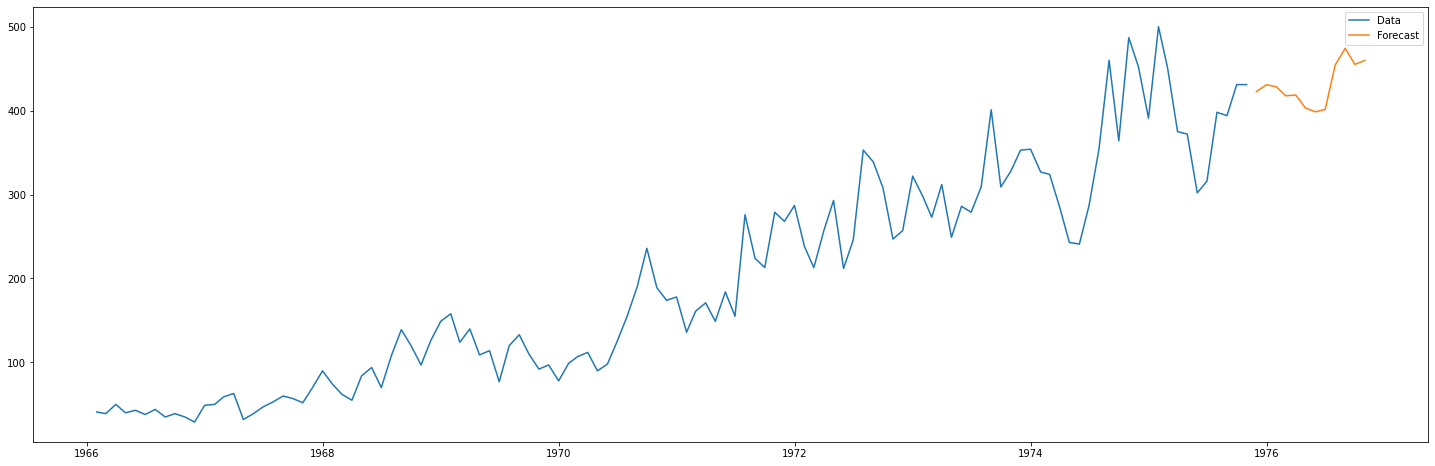

In [61]:
plt.plot(series, label='Data')
plt.plot(forecast_date, TES_add_predict, label='Forecast')
plt.legend()
plt.show()

# Conclusion
**It is forecasted that armed robberies are going to be increased in the next one year. Government and police has to take measure accordingly by imposing strict measures and deploying more man-force for patrolling**